In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Load simulation results

In [2]:
# Change the date time to the date time of the pickle file you want to load
date = '230816'
time = '1115'
date_time = date + '_' + time
path = './data/' + date + '/'
data_fanatics = path + date_time + '_fanatics.pkl'
data_fanatics = pd.read_pickle(data_fanatics)

data_no_fanatics = path + date_time + '_no_fanatics.pkl'
data_no_fanatics = pd.read_pickle(data_no_fanatics)

In [4]:
data_fanatics.describe()

,P,N,Q,W,A,B,beta,network_threshold,switching_cost,belief_difference,...,ENLITE,SECTS,CON,CLUSTERING_COEFFICIENT,MEAN_INDEGREE,MEDIAN_INDEGREE,MODE_INDEGREE,MIN_INDEGREE,MAX_INDEGREE,converged_time
count,90.0,90.0,90.0,90.0,9.000000e+01,9.000000e+01,90.000000,90.0,9.000000e+01,9.000000e+01,...,90.000000,90.000000,90.000000,90.000000,90.0,90.000000,90.000000,90.0,90.000000,90.000000
mean,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.550000,20.0,1.000000e-06,1.000000e-03,...,0.500478,3.888889,0.394252,0.113936,4.0,3.977778,3.488889,0.0,11.355556,102.533333
std,0.0,0.0,0.0,0.0,8.722209e-19,8.722209e-19,0.288837,0.0,2.129446e-22,2.180552e-19,...,0.254504,1.685660,0.162205,0.046136,0.0,0.127885,0.782454,0.0,1.455799,34.173451
min,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.100000,20.0,1.000000e-06,1.000000e-03,...,-0.018795,2.000000,0.110754,0.054899,4.0,3.000000,2.000000,0.0,9.000000,52.000000
25%,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.300000,20.0,1.000000e-06,1.000000e-03,...,0.366764,3.000000,0.271671,0.082453,4.0,4.000000,3.000000,0.0,10.000000,78.000000
50%,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.550000,20.0,1.000000e-06,1.000000e-03,...,0.496923,3.000000,0.371005,0.103272,4.0,4.000000,4.000000,0.0,11.000000,97.000000
75%,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.800000,20.0,1.000000e-06,1.000000e-03,...,0.710445,5.000000,0.505490,0.133488,4.0,4.000000,4.000000,0.0,12.000000,118.500000
max,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,1.000000,20.0,1.000000e-06,1.000000e-03,...,0.913252,9.000000,0.913618,0.246708,4.0,4.000000,5.000000,0.0,18.000000,201.000000


In [5]:
data_no_fanatics.describe()

,P,N,Q,W,A,B,beta,network_threshold,switching_cost,belief_difference,...,ENLITE,SECTS,CON,CLUSTERING_COEFFICIENT,MEAN_INDEGREE,MEDIAN_INDEGREE,MODE_INDEGREE,MIN_INDEGREE,MAX_INDEGREE,converged_time
count,10.0,10.0,10.0,10.0,1.000000e+01,1.000000e+01,10.000000,10.0,1.000000e+01,1.000000e+01,...,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.000000,10.0,10.000000,10.000000
mean,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.550000,20.0,1.000000e-06,1.000000e-03,...,0.817597,5.400000,0.261427,0.168014,4.0,4.0,3.400000,0.0,10.800000,120.200000
std,0.0,0.0,0.0,0.0,9.142795e-19,9.142795e-19,0.302765,0.0,2.232128e-22,2.285699e-19,...,0.117434,2.503331,0.095962,0.053750,0.0,0.0,0.699206,0.0,1.316561,39.037873
min,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.100000,20.0,1.000000e-06,1.000000e-03,...,0.496109,3.000000,0.099347,0.115328,4.0,4.0,3.000000,0.0,9.000000,68.000000
25%,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.325000,20.0,1.000000e-06,1.000000e-03,...,0.816388,4.000000,0.182751,0.139256,4.0,4.0,3.000000,0.0,10.000000,99.750000
50%,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.550000,20.0,1.000000e-06,1.000000e-03,...,0.855569,4.000000,0.279598,0.143805,4.0,4.0,3.000000,0.0,11.000000,114.000000
75%,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,0.775000,20.0,1.000000e-06,1.000000e-03,...,0.877028,6.500000,0.317136,0.174449,4.0,4.0,3.750000,0.0,11.750000,135.000000
max,200.0,4.0,1.0,1.0,5.000000e-03,5.000000e-03,1.000000,20.0,1.000000e-06,1.000000e-03,...,0.896147,11.000000,0.389648,0.277307,4.0,4.0,5.000000,0.0,13.000000,195.000000


## Last network

In [6]:
# Add the last network and belief to the data_fanatics DataFrame
data_fanatics['last_network'] = data_fanatics['network_array'].apply(lambda x: x[-1])
data_fanatics['last_belief'] = data_fanatics['belief_array'].apply(lambda x: x[-1])

In [7]:
# Add the last network and belief to the data_non_fanatics DataFrame
data_no_fanatics['last_network'] = data_no_fanatics['network_array'].apply(lambda x: x[-1])
data_no_fanatics['last_belief'] = data_no_fanatics['belief_array'].apply(lambda x: x[-1])

## In-degree

In [8]:
def get_indegree(network):
    G = nx.from_numpy_array(network, create_using=nx.DiGraph)
    indegree = np.array([G.in_degree(n) for n in G.nodes()])
    return indegree

In [9]:
data_fanatics['last_indegree'] = data_fanatics['last_network'].apply(lambda x: get_indegree(x))
data_no_fanatics['last_indegree'] = data_no_fanatics['last_network'].apply(lambda x: get_indegree(x))

## Split dataset by `fanatics_scheme`

3 datasets
- `fanatics_scheme == 'max'`: all fanatics have a belief of 1.
- `fanatics_scheme == 'min-max'`: half of the fanatics have a belief of 0, the other half have a belief of 1.
- `fanatics_scheme == 'mean'`: all fanatics have a belief of 0.5.

In [11]:
data_fanatics_max = data_fanatics[data_fanatics['fanatics_scheme'] == 'max']
data_fanatics_min_max = data_fanatics[data_fanatics['fanatics_scheme'] == 'min-max']
data_fanatics_mean = data_fanatics[data_fanatics['fanatics_scheme'] == 'mean']

In [12]:
# For each fanatics scheme, we concat the results of the simulations with fanatics and the results of the simulations without fanatics.
fanatics_max = pd.concat([data_no_fanatics, data_fanatics_max])
fanatics_min_max = pd.concat([data_no_fanatics, data_fanatics_min_max])
fanatics_mean = pd.concat([data_no_fanatics, data_fanatics_mean])

In [13]:
fanatics_max['fanatics_scheme'] = 'max'
fanatics_min_max['fanatics_scheme'] = 'min-max'
fanatics_mean['fanatics_scheme'] = 'mean'

In [14]:
fanatics_max.shape, fanatics_min_max.shape, fanatics_mean.shape

((40, 30), (40, 30), (40, 30))

# Visualize

## Network-belief coevolution

### Helper functions

In [15]:
def visualize_beliefs_helper(beliefs: np.ndarray, ax: plt.Axes) -> plt.figure:
    """
    Visualize clusters of beliefs in different periods of the network. 
    This is the core function behind Graeme's Figure 1+4.

    People in the same subnetwork tend to have the same beliefs

    Params:
        beliefs (np.ndarray): The belief of each person in the network
        conv (int): the current period of the simulation. If 0, don't show. If -1, "converged".
        ax (plt.Axes): the figure's axes instance

    Returns:
        fig: The figure of the belief of people (in Graeme's paper)
    """
    # Sort belief and plot
    sorted_b = np.sort(beliefs)[::-1]

    # Plot figure
    ax.set_box_aspect(1/3)
    fig = ax.barh(list(range(len(sorted_b))), sorted_b, height=1)
    ax.xaxis.set_ticks(np.arange(0, 1.1, 0.2))
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, len(sorted_b))
    ax.yaxis.set_visible(False)
    return fig

def visualize_network_helper(beliefs: np.ndarray, networks: np.ndarray, conv: int, ax: plt.Axes) -> plt.figure:
    """
    Visualize segments/clusters of the network.
    This is the core function behind Graeme's Figure 4.

    Params:
        beliefs (np.ndarray): The belief of each person in the network
        networks (np.ndarray): The network of people
        conv (int): The current period of the simulation
        ax (plt.Axes): the figure's axes instance

    Returns:
        fig: The figure of the networks of people
    """
    # Sort people according to beliefs
    members = np.argsort(np.argsort(beliefs))
    # Convert matrix to dictionary
    network = {i: np.where(networks[i] == 1) for i in range(networks.shape[0])}
    # Reindex people according to sorted beliefs
    sort_network = {members[i]: [members[fr]
                                 for fr in network[i]] for i in range(len(members))}

    # Create array for scatter plot
    sort_y = np.array([[y, y, y, y]
                      for y in list(sort_network.keys())]).flatten()
    sort_x = np.array(list(sort_network.values())).flatten()

    # Plot figure
    ax.set(xlim=(0, np.max(sort_x)), ylim=(np.max(sort_y), 0))
    ax.set_box_aspect(1)
    fig = ax.scatter(sort_x, sort_y, 0.2)
    conv = str(conv) if conv != -1 else "converged"
    ax.set_xlabel(f"t = {conv}")
    ax.tick_params(labelbottom='off')
    ax.yaxis.set_visible(False)

    return fig

def visualize_coevolution(results: pd.DataFrame, fanatics_scheme: str, beta: float, export=False) -> plt.figure:
    """
    Graeme's Figure 4: Coevolution of Beliefs and Networks

    Params:
        results (pd.DataFrame): The results of the simulations
        beta (float): Social dissonance value
        export (bool): Export this figure if `true`
        name (str): the OUTPUT_NAME of this program

    Returns:
        fig: The figure of networks & beliefs coevolution (in Graeme's paper)
    """
    # 10 different graphs for 10 fanatic values
    fig, axs = plt.subplots(nrows=4, ncols=8, gridspec_kw={'width_ratios': [1, 3, 1, 3, 1, 3, 1, 3]}, figsize=(15, 8))

    # Loop through different values of num_fanatics
    for i, num_fanatics in enumerate(results['num_fanatics'].unique()):
        df = results[(results['num_fanatics'] == num_fanatics)
                     & (results['beta'] == beta)]

        # Visualize belief at 4 different time steps
        timesteps = [1, 5, 25, -1]

        for j, time in enumerate(timesteps):
            visualize_network_helper(df['belief_array'].iloc[0][j],
                                     df['network_array'].iloc[0][j],
                                     time, axs[j, (i % 4)*2])
            # df['belief_array] is a list of np.ndarray of beliefs at time t
            visualize_beliefs_helper(df['belief_array'].iloc[0][j],
                                     axs[j, (i % 4)*2+1])

        axs[i // 4, (i % 4)*2].set_title(f"Fanatics = {num_fanatics}")
    
    scheme = ''
    if fanatics_scheme == 'max':
        scheme = 'All fanatics hold the highest beliefs'
    elif fanatics_scheme == 'min-max':
        scheme = 'Half of the fanatics hold the highest beliefs, the other half hold the lowest beliefs'
    elif fanatics_scheme == 'mean':
        scheme = 'All fanatics hold the beliefs in the middle'
    fig.suptitle(f"Coevolution of beliefs and networks \n ({scheme}) \n (beta = {round(beta, 2)})")
    plt.tight_layout()

    # Save figure
    if export:
        try:
            os.mkdir(f'./plots/{date}')
        except FileExistsError:
            pass
        plt.savefig(f'./plots/{date}/{date_time}_coev_{fanatics_scheme}_{round(beta, 2)}.png', facecolor='white')
    plt.close()
    return fig

### Results

In [17]:
beta = fanatics_max['beta'].unique()
for b in beta:
    visualize_coevolution(results=fanatics_max, fanatics_scheme='max', beta=b, export=True)

In [18]:
beta = fanatics_min_max['beta'].unique()
for b in beta:
    visualize_coevolution(results=fanatics_min_max, fanatics_scheme='min-max', beta=b, export=True)

In [19]:
beta = fanatics_mean['beta'].unique()
for b in beta:
    visualize_coevolution(results=fanatics_mean, fanatics_scheme='mean', beta=b, export=True)

## In-degree

In [20]:
def visualize_indegree(data: pd.DataFrame, fanatics_scheme: str):
    """Visualize the distribution of in-degrees."""
    scheme = ''
    if fanatics_scheme == 'max':
        scheme = "all fanatics' beliefs=1"
    elif fanatics_scheme == 'min-max':
        scheme = "half of the fanatics' beliefs=1, the other half=0"
    elif fanatics_scheme == 'mean':
        scheme = "all fanatics' beliefs=0.5"

    temp = data.explode('last_indegree')
    palette = sns.color_palette("hls", 10)
    g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
    g_indegree.set_axis_labels('In-degree', 'Count')
    g_indegree.set_titles('Number of fanatics: {col_name}')
    g_indegree.fig.suptitle(f'Distribution of in-degrees ({scheme})', y=1.05)
    plt.legend(title='beta', labels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    # g_indegree.savefig(f'./plots/{date_time}_indegree_{fanatics_scheme}.png')
    plt.show(g_indegree)

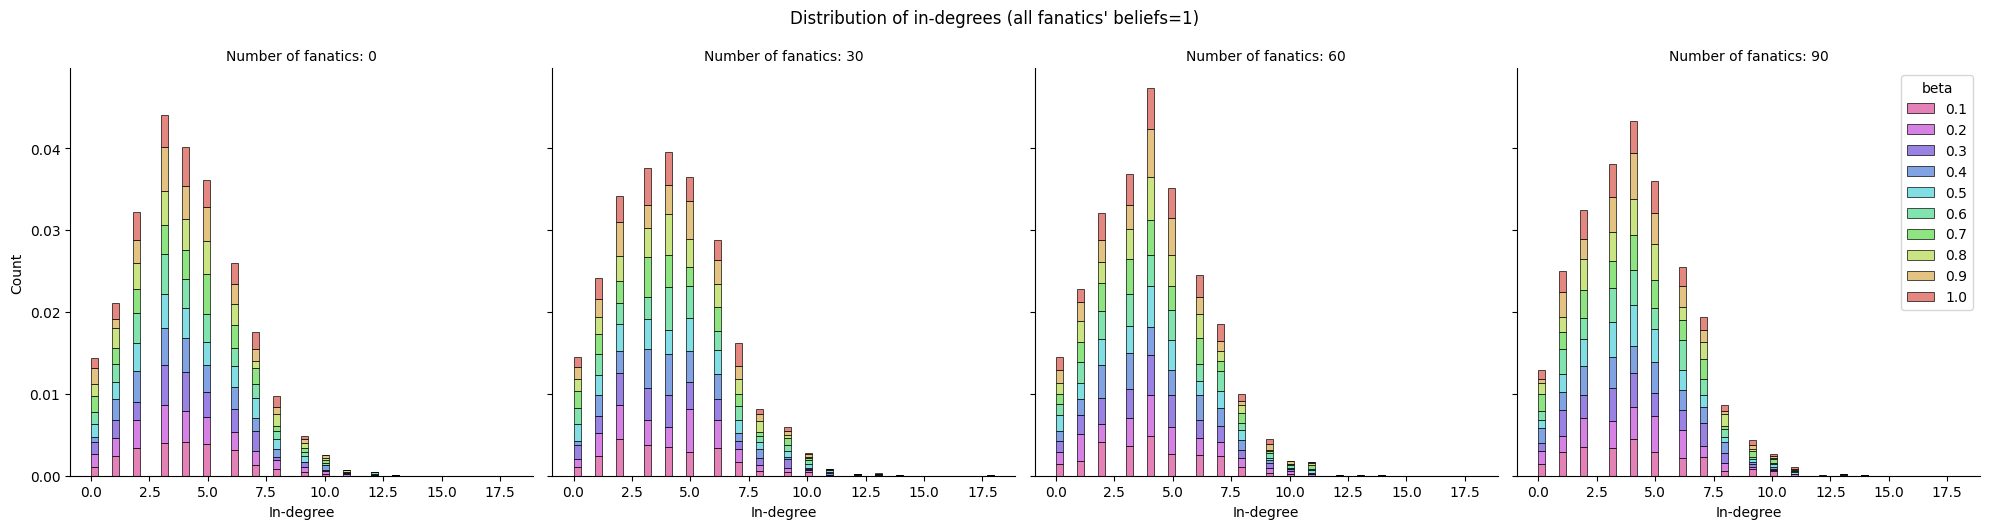

In [21]:
visualize_indegree(fanatics_max, fanatics_scheme='max')

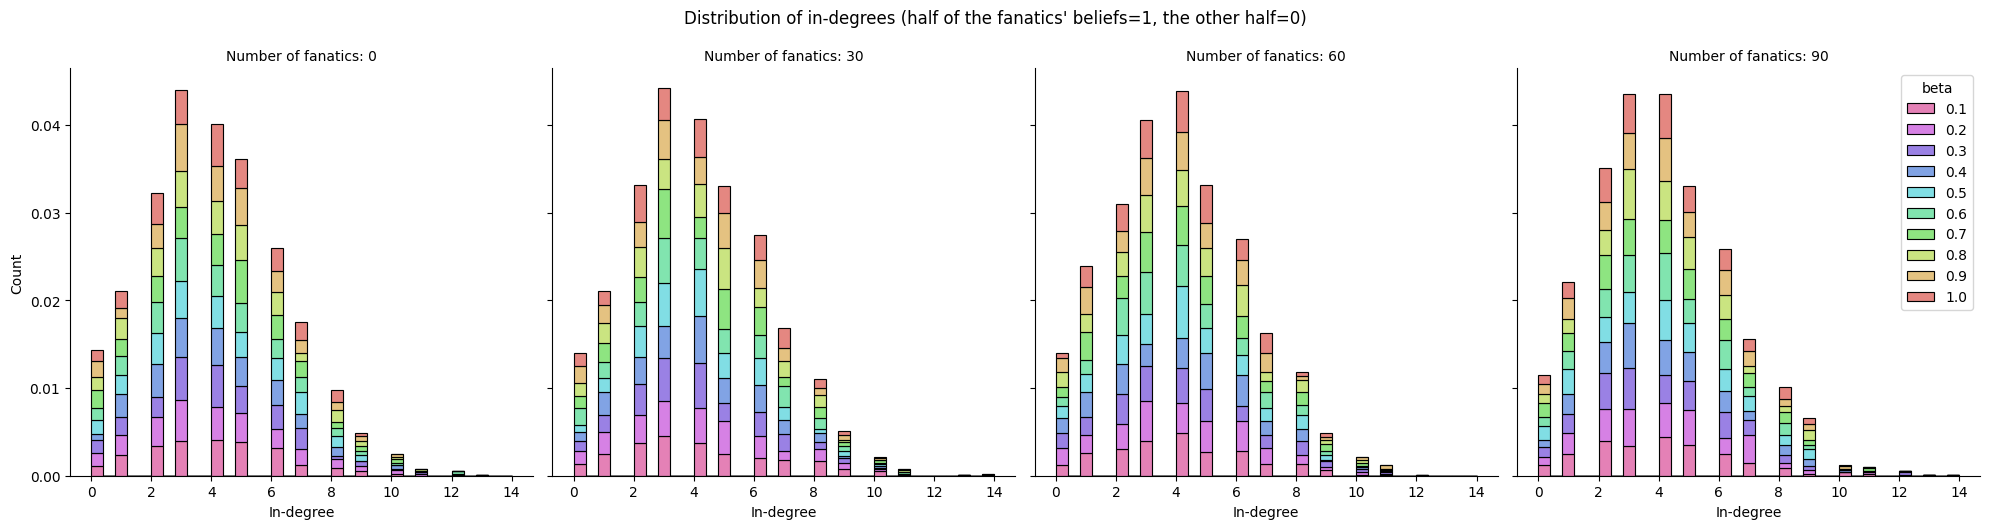

In [22]:
visualize_indegree(fanatics_min_max, fanatics_scheme='min-max')

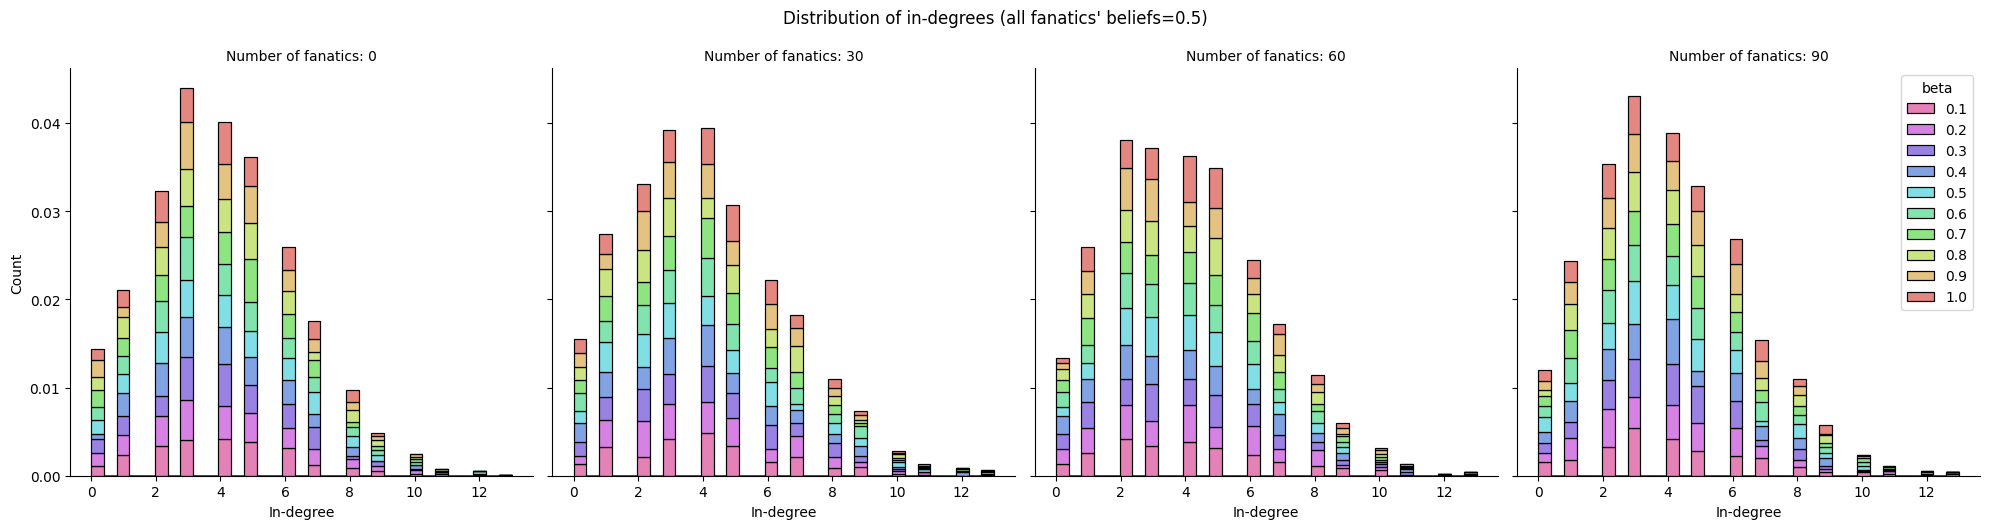

In [23]:
visualize_indegree(fanatics_mean, fanatics_scheme='mean')

## Metrics

In [24]:
metrics= ['MEAN', 'STDEV', 'BIAS', 'ENLITE', 'SECTS', 'CON', 'CLUSTERING_COEFFICIENT', 'MEAN_INDEGREE','MEDIAN_INDEGREE', 'MODE_INDEGREE', 'MIN_INDEGREE', 'MAX_INDEGREE']

In [ ]:
# sns.relplot(
#     data=data, x='beta', y='CON', col="num_fanatics", col_wrap=4, kind="line")
# plt.show()

In [27]:
def line_plot(data, metric):
    """
    Create a line plot of the metric over the beta values.
    """
    sns.lineplot(data=data, x='beta', y=metric, hue='num_fanatics')
    plt.title(f'{metric} vs. beta')
    plt.show()

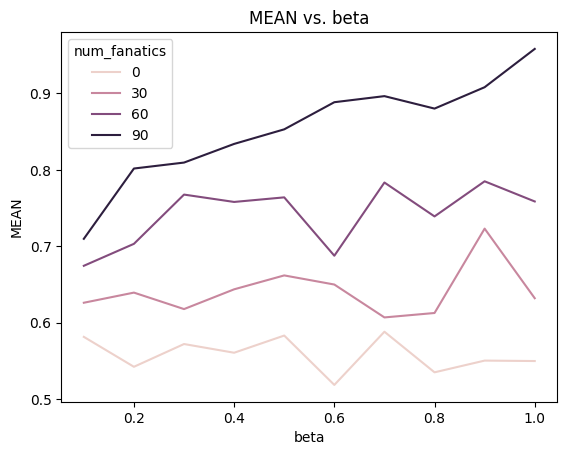

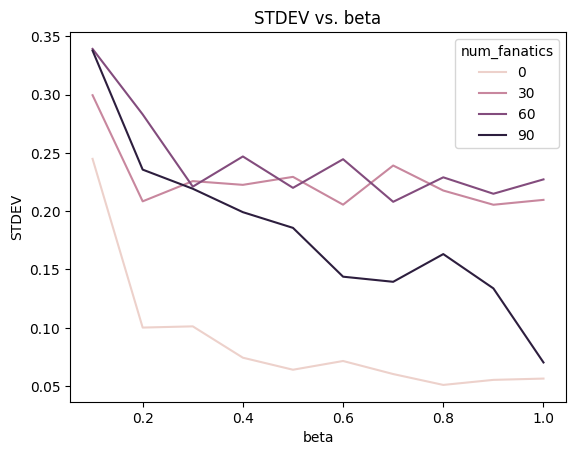

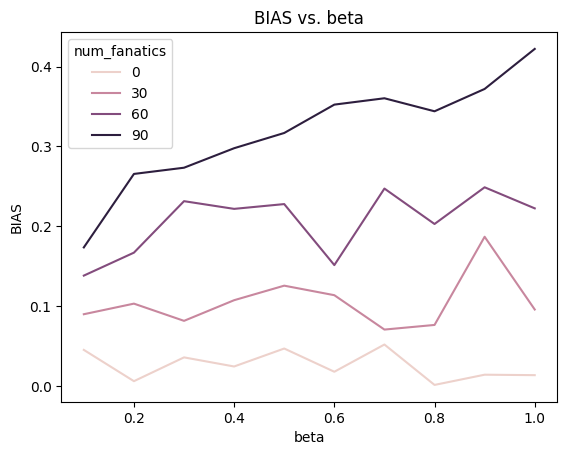

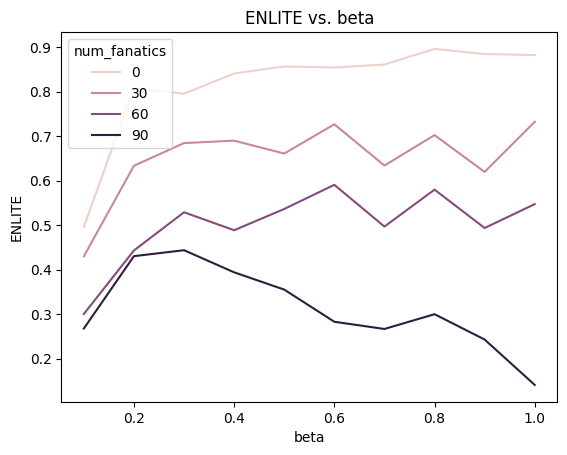

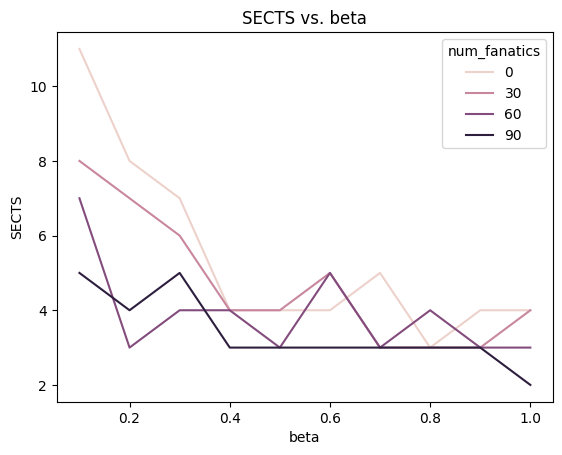

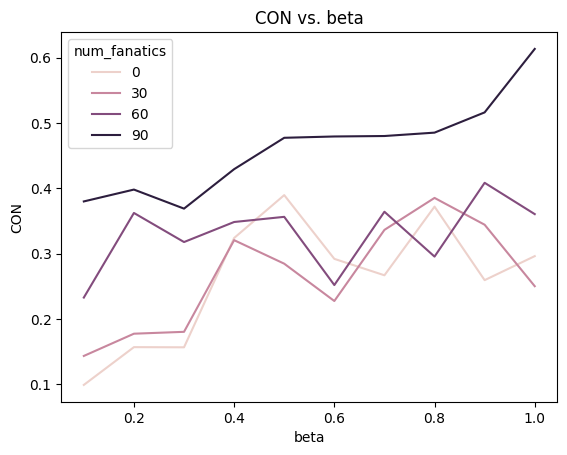

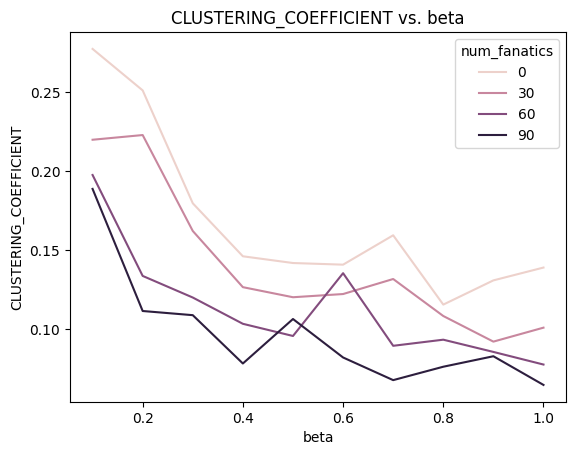

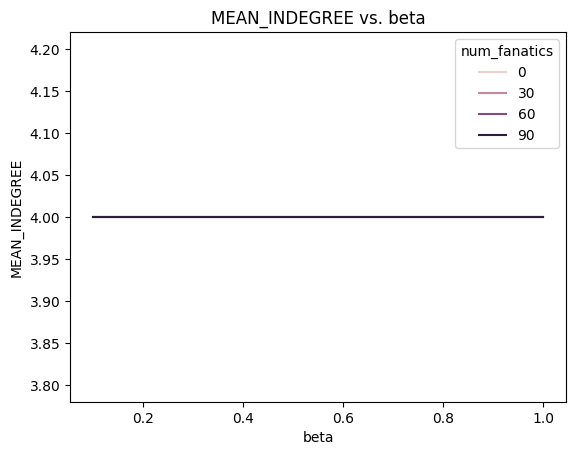

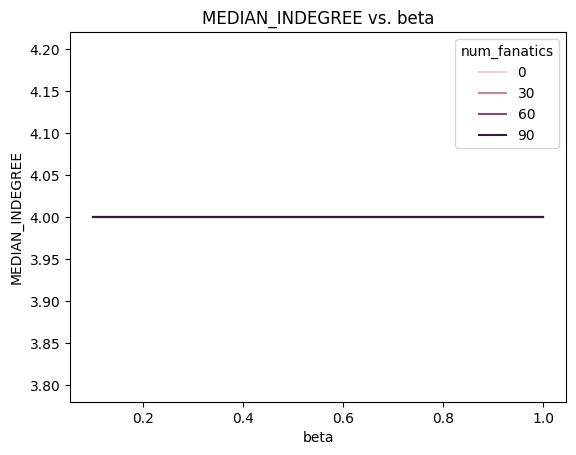

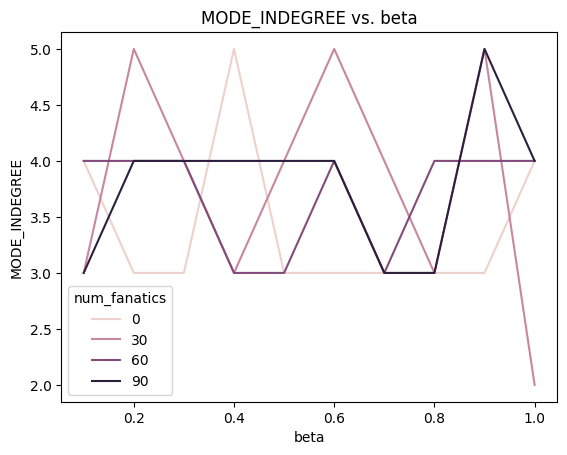

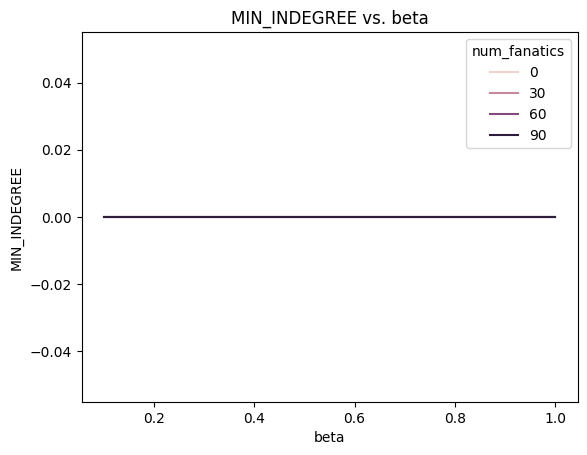

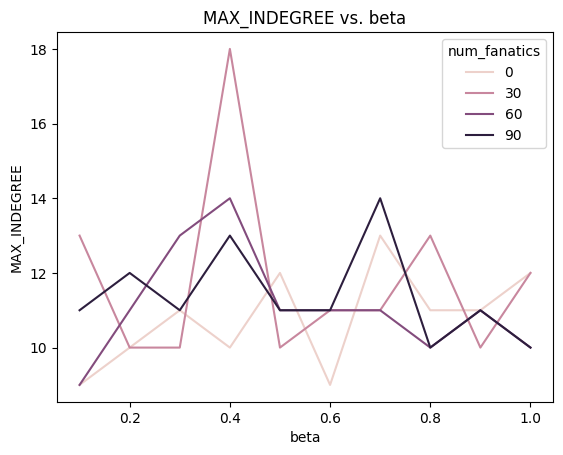

In [28]:
for metric in metrics:
    line_plot(fanatics_max, metric)

# Do the same thing for other fanatics schemes

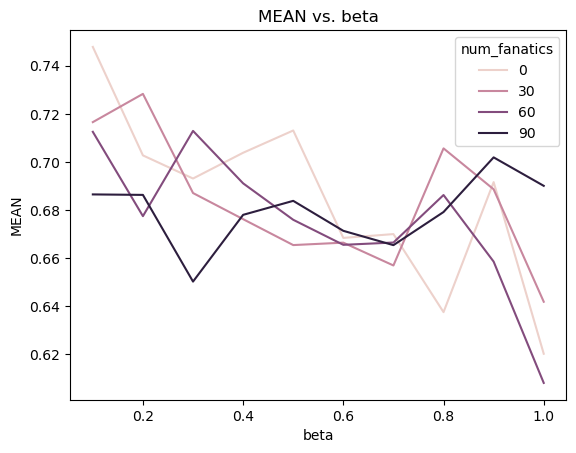

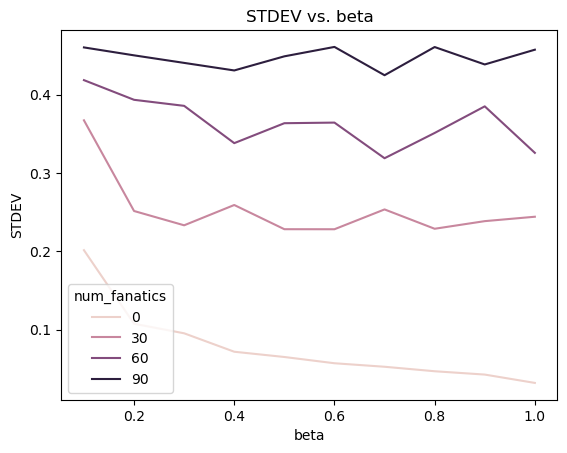

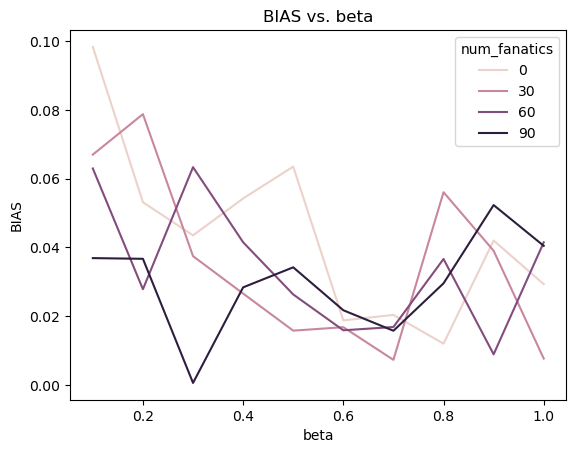

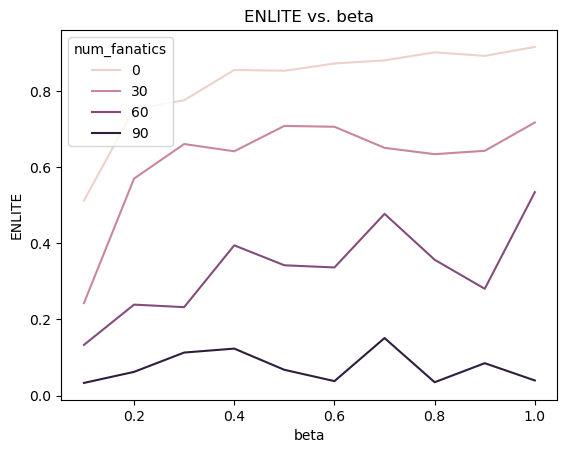

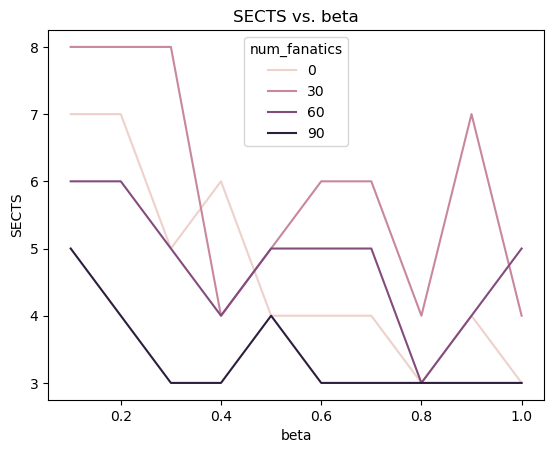

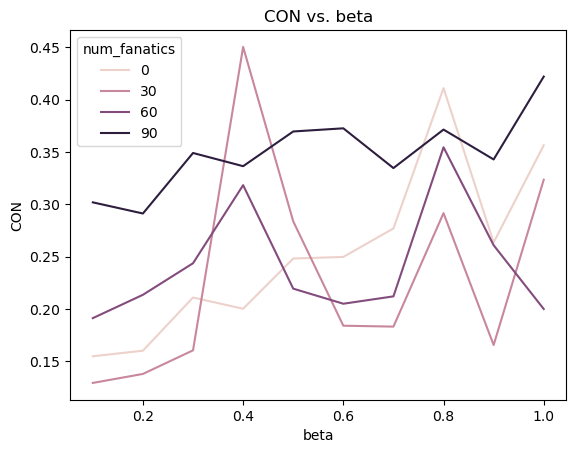

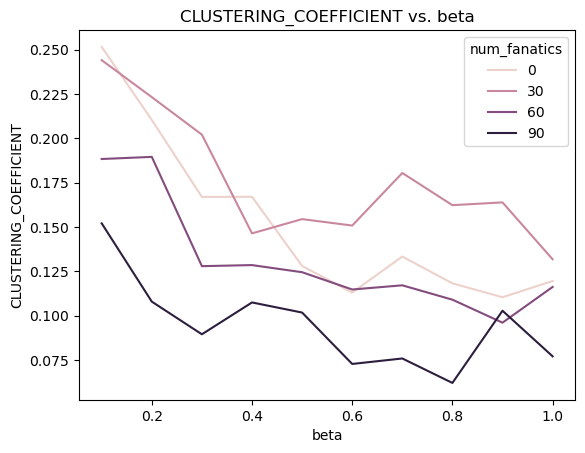

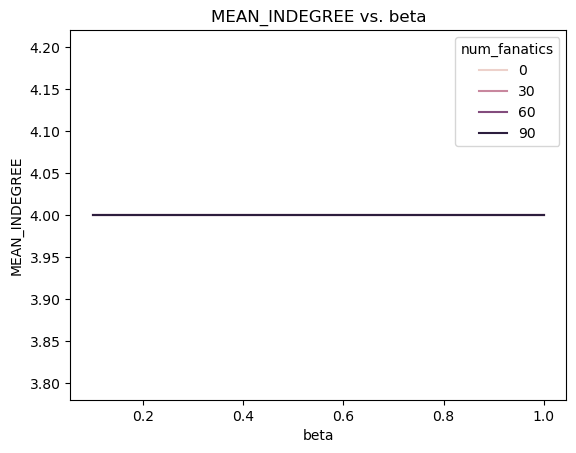

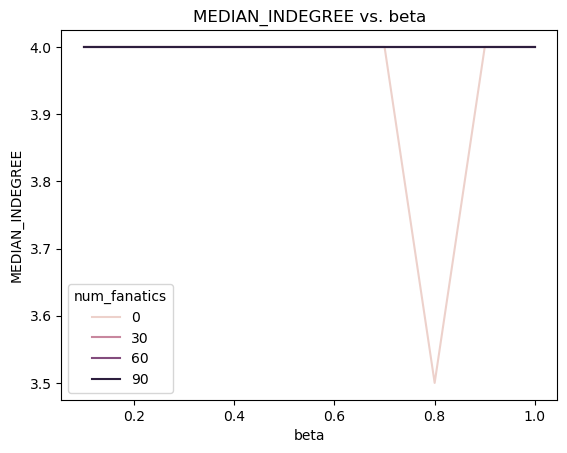

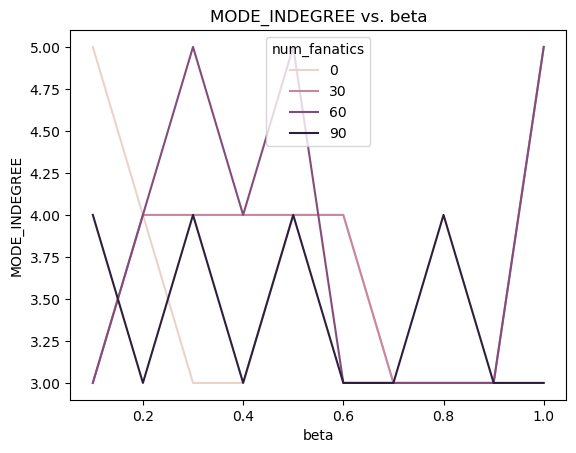

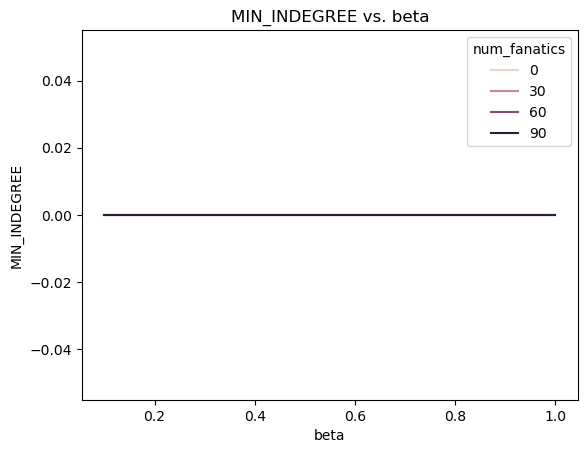

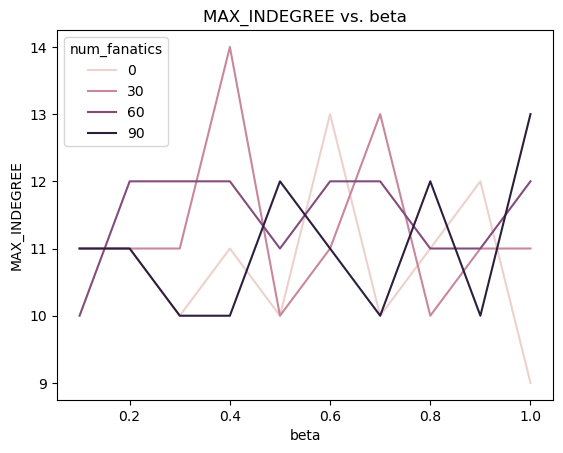

In [ ]:
for metric in metrics:
    line_plot(fanatics_min_max, metric)

# Do the same thing for other fanatics schemes

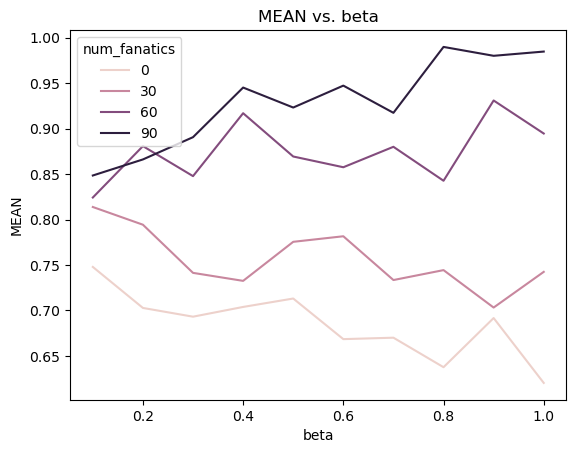

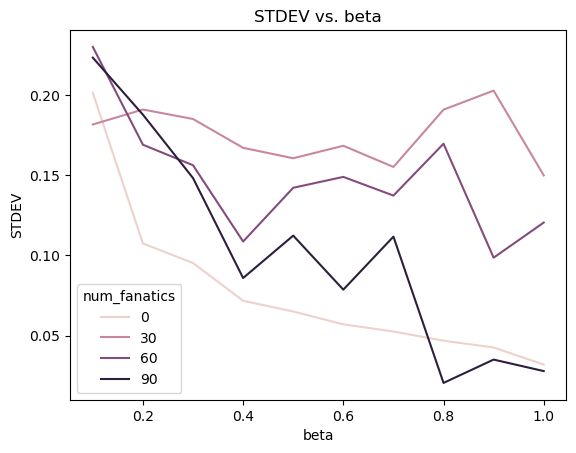

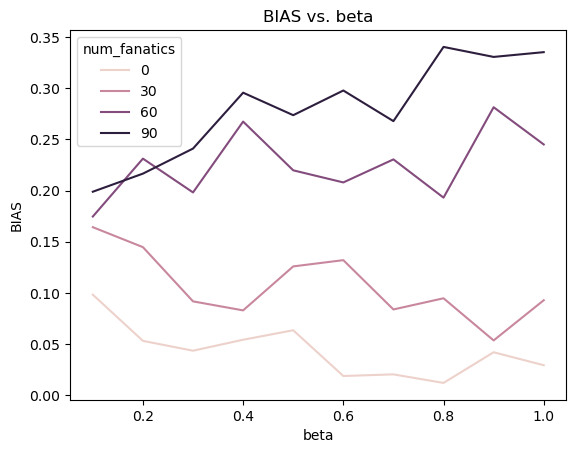

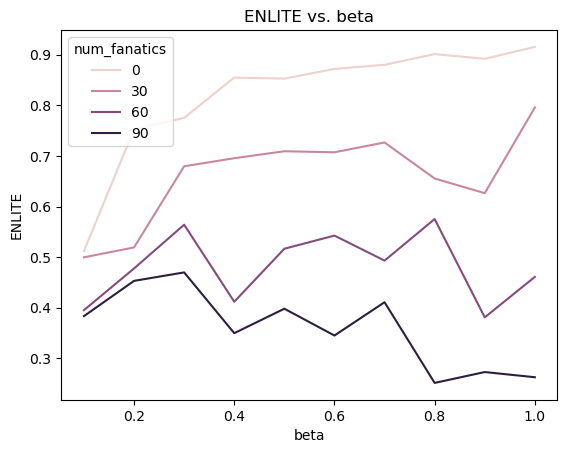

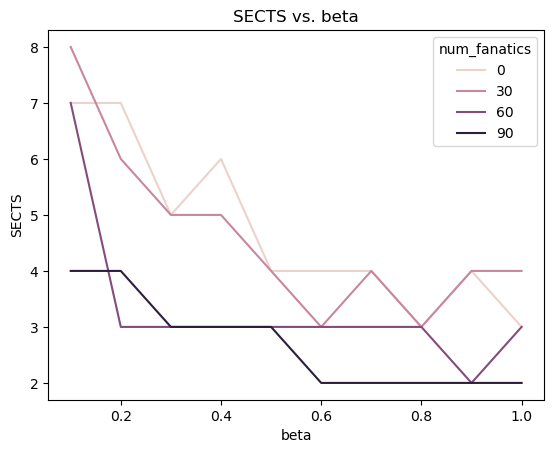

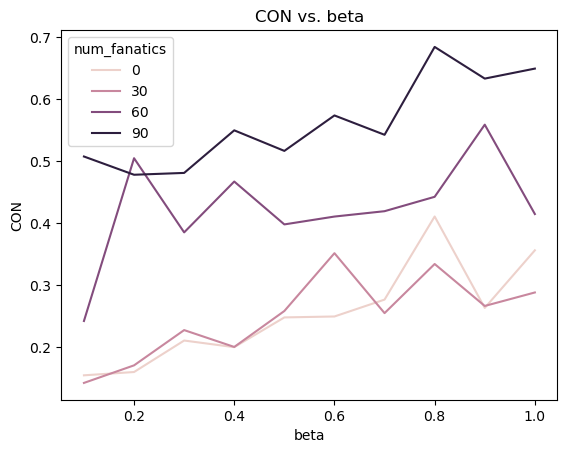

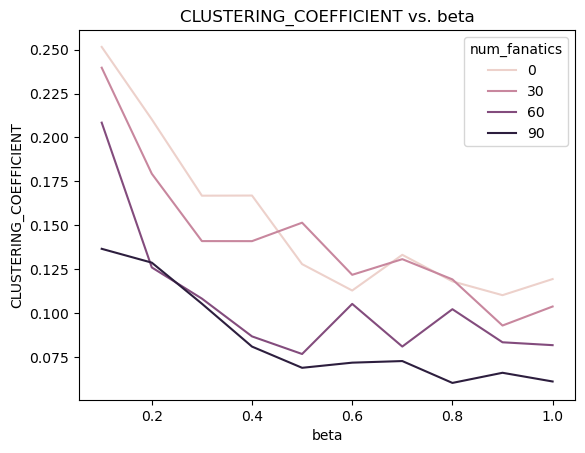

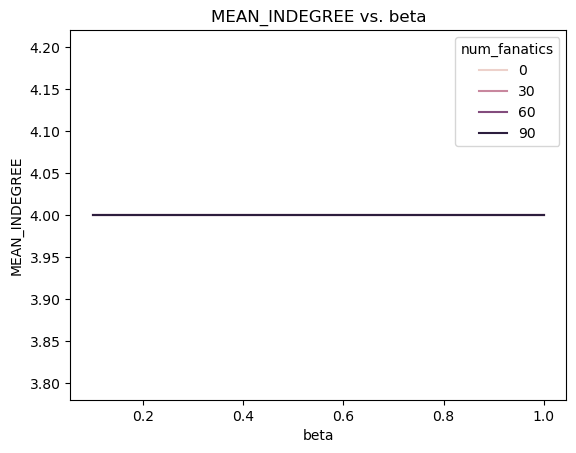

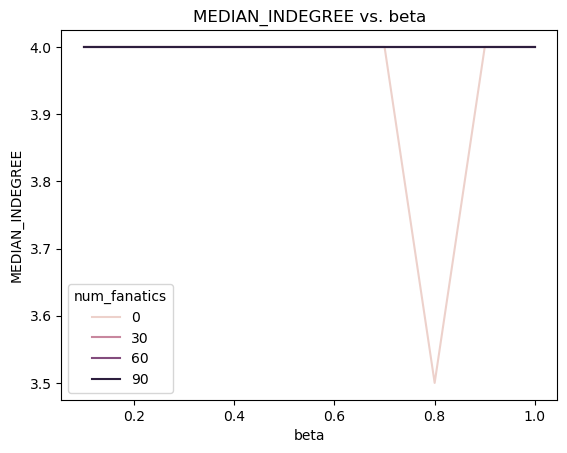

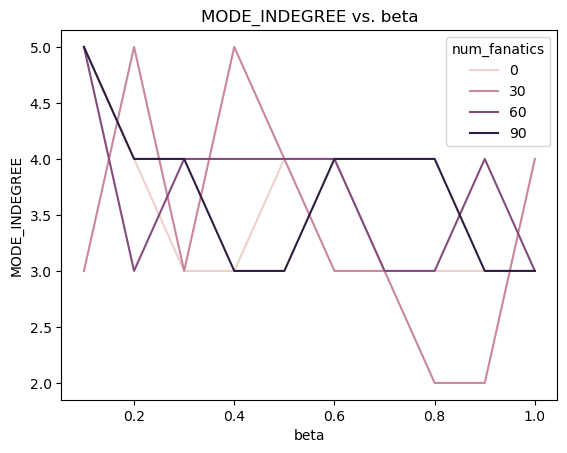

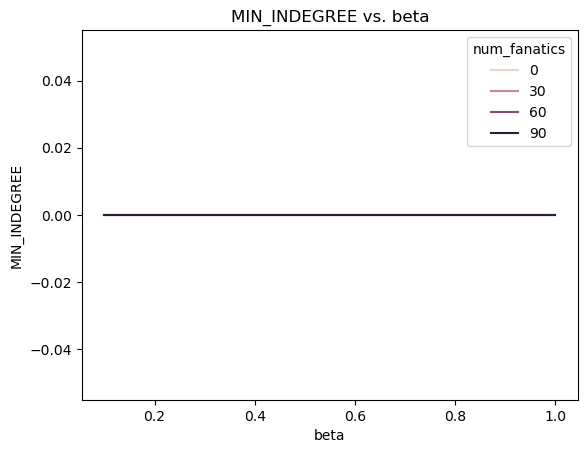

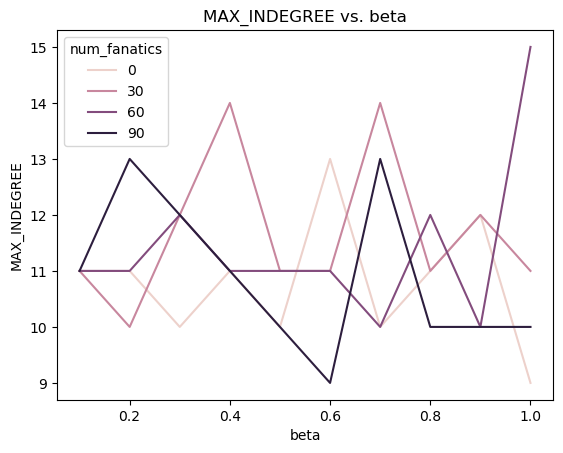

In [ ]:
for metric in metrics:
    line_plot(fanatics_mean, metric)

# Do the same thing for other fanatics schemes